 This notebook is to calibrate SNe Ia and and calcualte H0.  

In [372]:
# Importing necessary libraries 
import sys
import numpy as np
import emcee
import astropy.io.fits as pyfits
import matplotlib.pylab as pl
import random,os
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
from astropy.io import ascii
import corner
from astropy.table import join,vstack,unique, Table


Defining computing resources

In [373]:
ncpu = cpu_count()
print("{0} CPUs".format(ncpu))
os.environ["OMP_NUM_THREADS"] = "1"

8 CPUs


In [374]:
np.float = float    
np.int = int   #module 'numpy' has no attribute 'int'
np.object = object    #module 'numpy' has no attribute 'object'
np.bool = bool    #module 'numpy' has no attribute 'bool'

Read files containing calibrators and distant SNe Ia. All files are at ../data/working/ directory

In [375]:
tab = ascii.read('../data/working/H_ceph_update3.csv')
#tab1['VPEC_1'] = 0.0
#tab1['zCMB_1'] = 0.0

pec = ascii.read('/Users/uddin/Dropbox/Scripts/github/h0csp/data/hosts/varonly_cspsne_090923.csv')

pec.rename_column('CID_1','sn')
pec.remove_column('VPEC_VARIANCE')
pec.remove_column('NONGAUSS')

#tab = join(tab1,pec,keys='sn')

#remove = ['SN1990N','SN1994ae', 'SN1995al', 'SN1998aq', 'SN2005W']

#tab.remove_rows([164,165,166,167,178])



In [376]:
#file = 'B_sbfj21_update3.csv' # change the filaname here if needed for other bands or for other calibrators
#tab = ascii.read('../data/working/'+file)

In [377]:
c = 300000.
q=-0.53

Here we select sample from the original sample

In [378]:
# Excluding peculiar events
w = np.where( (tab['sn']!='CSP14abk') &  (tab['sn']!='PTF13dyt') &  (tab['sn']!='PTF13dym') & (tab['sn']!='PTF14yw') & (tab['sn']!='PS1-13eao') & (tab['subtype']!='Ia-SC') & (tab['subtype']!='Ia-02cx') & (tab['sn']!='LSQ14fmg')& (tab['sn']!='SN2004dt')& (tab['sn']!='SN2005gj')& (tab['sn']!='SN2005hk')& (tab['sn']!='SN2006bt')& (tab['sn']!='SN2006ot')& (tab['sn']!='SN2007so')& (tab['sn']!='SN2008ae')& (tab['sn']!='SN2008bd')& (tab['sn']!='SN2008ha')& (tab['sn']!='SN2008J')& (tab['sn']!='SN2009dc')& (tab['sn']!='SN2009J')& (tab['sn']!='SN2010ae'))

Reading all parameters from the input file and marking distance hosts.

In [379]:
# LC and host
st = tab['st'][w]
est = tab['est'][w]
zhel = tab['zhel'][w]
zcmb = tab['zcmb'][w]
mmax = tab['Mmax'][w]
emmax = tab['eMmax'][w]
bv =tab['BV'][w]
ebv = tab['eBV'][w]
m_csp = tab['m'][w]
eml = (tab['m'][w]-tab['ml'][w])
emu = (tab['mu'][w]-tab['m'][w])
em = (emu+eml)/2.

dist = tab['dist'][w]
edist = tab['edist'][w]
c_ms = tab['covMs'][w]
c_mbv = tab['covBV_M'][w]
sn = tab['sn'][w]
cal = tab['caltype'][w]
quality = tab['quality'][w]



#zpec = tab['VPEC_1'][w]/c
#zcosmo = ((1+zcmb)/(1+zpec)) -1


#data =Table()
#data['sn']=sn
#data['zcmb']= zcmb
#data['zcosmo'] = zcosmo


#print(data)

#pl.plot(zcmb,quality, 'bo')
ww = np.where(sn=='SN2005W')
print(sn[ww])
#ascii.write(data,'../results/forAdam/CSP_zcosmo.txt',format='tab',overwrite=True)


 sn
---


In [380]:
#adding more calibrators from Garnavich 2023
#1
"""
c1 = np.where(sn =='SN2006mr') #31.200 ± 0.093
dist[c1]=31.2
edist[c1]=0.093
#2
c2 = np.where(sn =='SN2007on') # 31.453 ± 0.084
dist[c2]=31.453
edist[c2]=0.084
#3
c3 = np.where(sn =='SNhunt281')# 32.369,0.078 same as SN2015bp from Jensen 2021
dist[c3]=32.369
edist[c3]=0.078
"""

print("Distant SNe Ia: ", np.sum(dist<0))

print("Calibrating SNe Ia :", np.sum(dist>0.))


Distant SNe Ia:  207
Calibrating SNe Ia : 20


In [381]:
#initial guess
plim=-19.3, -19.2
p1lim =-1.2,-1.1
p2lim=-.055,-0.05
rvlim =2.7,2.71
alphalim=-0.11,-0.1
siglim=0.1,.12
vellim =300.,310
h0lim= 71.0,71.1

In [382]:
# Eqn 9 of Bruns 2018
def distmod(h,z1,z2):
    t1 = (1+z1)/(1+z2)
    t2 = (c*z2)/h
    t3 = 1 + (((1-q)/2)*z2)
    return (5*np.log10(t1*t2*t3)) +25


In [383]:
# Liklihood function
def like(par):
    p,p1,p2,rv,alpha,sig,vel,h0 = par
    if  -25.0<p<-15.0  and -5.0<p1<5.0 and -5.0<p2<5.0 and -5.<rv<5.0 and -1.<alpha<1. and 0.<sig<0.5 and 0.<vel<1000. and  0< h0 < 1000.0: # priors
        

        
        mu_obs = mmax - p - p1*(st - 1.) -  p2*(st - 1.)**2 - rv*bv - alpha*(m_csp-np.median(m_csp))
        #mu_obs = mmax - p - p1*(st - 1.) -  p2*(st - 1.)**2 - rv*bv - (alpha*m_csp) # slope 


        mu_model = np.where(dist<0, distmod(h0,zhel,zcmb), dist)

        fac= (p1+(2*p2*st))
        velterm = (2.17*vel)**2/(c*zcmb)**2
        err = (fac*est)**2 +emmax**2 +(rv*ebv)**2+2*fac*c_ms+rv*c_mbv+sig**2+(0.00000723*vel/zcmb)**2 +(alpha*em)**2
        err1 = ((fac*est)**2) +(emmax**2) +((rv*ebv)**2)+(2*fac*c_ms)+(rv*c_mbv)+sig**2+(edist**2)+(alpha*em)**2#
    
        mu_stat = np.where(dist<0,err,err1)

      
        mu_stat=np.sqrt(mu_stat)
        dmu=mu_obs-mu_model
        
        chi =np.sum((dmu)**2/mu_stat**2)
        return -0.5*chi - (0.5*np.sum(np.log(2*np.pi*(mu_stat)**2))) 
    else:
        return -np.inf

In [384]:
# EMCEE
ndim, nwalkers = 8, 80
ssize=1000
burnin = 500


p00 = np.random.rand(nwalkers) * (plim[1] - plim[0]) + plim[0]
p10 = np.random.rand(nwalkers) * (p1lim[1] - p1lim[0]) + p1lim[0]
p20 = np.random.rand(nwalkers) * (p2lim[1] - p2lim[0]) + p2lim[0]
rv0 = np.random.rand(nwalkers) * (rvlim[1] - rvlim[0]) + rvlim[0]
alpha0 = np.random.rand(nwalkers) * (alphalim[1] - alphalim[0]) + alphalim[0]
sig0 = np.random.rand(nwalkers) * (siglim[1] - siglim[0]) + siglim[0]
vel0 = np.random.rand(nwalkers) * (vellim[1] - vellim[0]) + vellim[0]
h00 = np.random.rand(nwalkers) * (h0lim[1] - h0lim[0]) + h0lim[0]

#p0 = zip(*[p00,p10,p20,rv0,alpha0,sig0,vel0,h00])
p0 = np.array([p00,p10,p20,rv0,alpha0,sig0,vel0,h00]).T

In [385]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, like)
print ("running mcmc on ")
start = time.time()
sampler.run_mcmc(p0,ssize,progress=True)
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
end = time.time()
serial_time = end - start

running mcmc on 


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 36.52it/s]


Autocorrelation time: [111.7674402   29.30035969  85.31973501 107.42703962  86.34115254
  89.49389344  30.27680137 112.7832361 ]


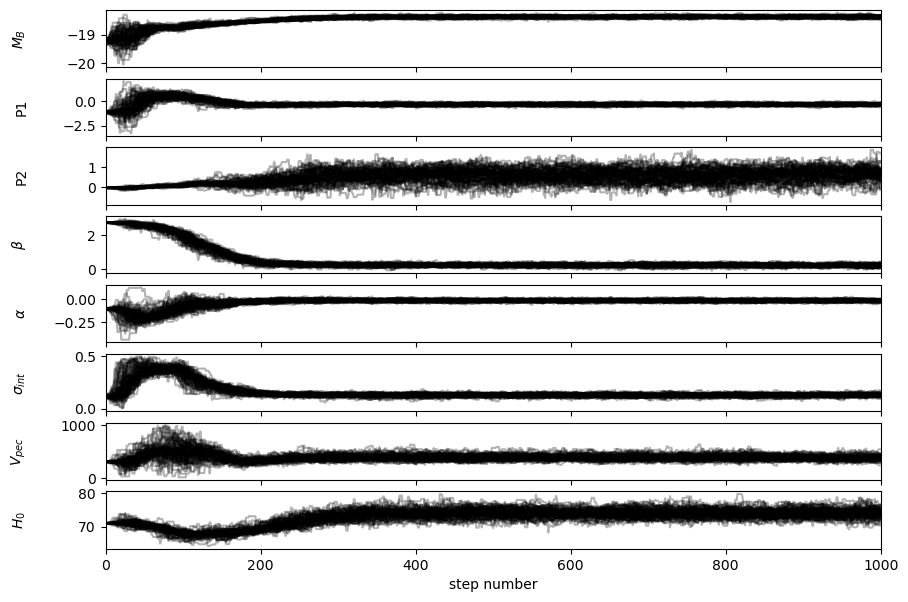

In [386]:
# Chains
fig, axes = pl.subplots(8, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["$M_B$","P1", "P2", r"$\beta$",r"$\alpha$", r"$\sigma_{int}$",r"$V_{pec}$", r"$H_0$"]
for j in range(ndim):
    ax = axes[j]
    ax.plot(samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

#fig.savefig("../plots/steps_"+file[:-4]+"_"+str(nwalkers)+"_"+str(ssize)+".pdf")

samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))

#tau = sampler.get_autocorr_time()
#print(tau)


# Assume `sampler` is your emcee.EnsembleSampler instance
tau = sampler.get_autocorr_time(tol=0)  # Returns an array of τ for each parameter
print(f"Autocorrelation time: {tau}")

# Check if the chain is long enough
n_steps = sampler.iteration
if n_steps < 50 * max(tau):
    print("Warning: The chain might not have converged yet!")


In [387]:
# Printing results
p0_mcmc,p1_mcmc,p2_mcmc,rv_mcmc,alpha_mcmc,sig_mcmc,vel_mcmc, H0_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))


print("""MCMC result:
    P0 = {0[0]} +{0[1]} -{0[2]} 
    P1 = {1[0]} +{1[1]} -{1[2]} 
    P2 = {2[0]} +{2[1]} -{2[2]} 
    Beta = {3[0]} +{3[1]} -{3[2]}
    Alpha = {4[0]} +{4[1]} -{4[2]}
    Sigma = {5[0]} +{5[1]} -{5[2]}
    Vpec = {6[0]} +{6[1]} -{6[2]}
    H0 = {7[0]} +{7[1]} -{7[2]}

   
""".format(p0_mcmc, p1_mcmc, p2_mcmc,rv_mcmc,alpha_mcmc,sig_mcmc,vel_mcmc, H0_mcmc))


MCMC result:
    P0 = -18.37509329424261 +0.03462986894350806 -0.03464694951514957 
    P1 = -0.34685270155664627 +0.11191070013095603 -0.1044149202042382 
    P2 = 0.6102192021842707 +0.30583092718216065 -0.3390005975171948 
    Beta = 0.21807001705341036 +0.07755726411174999 -0.08123554689340484
    Alpha = -0.01700563894597597 +0.012448355922654957 -0.011683078089233686
    Sigma = 0.12848170166705336 +0.013574567988255931 -0.01391626540431129
    Vpec = 383.6896458471635 +47.97655644737961 -44.05652270601439
    H0 = 74.0422816152898 +1.2806444852479615 -1.2715740091874608

   



Same 20 calibrators 
B-band Ho = 72.26 (1.55)
H-band H0 = 74.01 (1.29)

Serial took 0.5 minutes


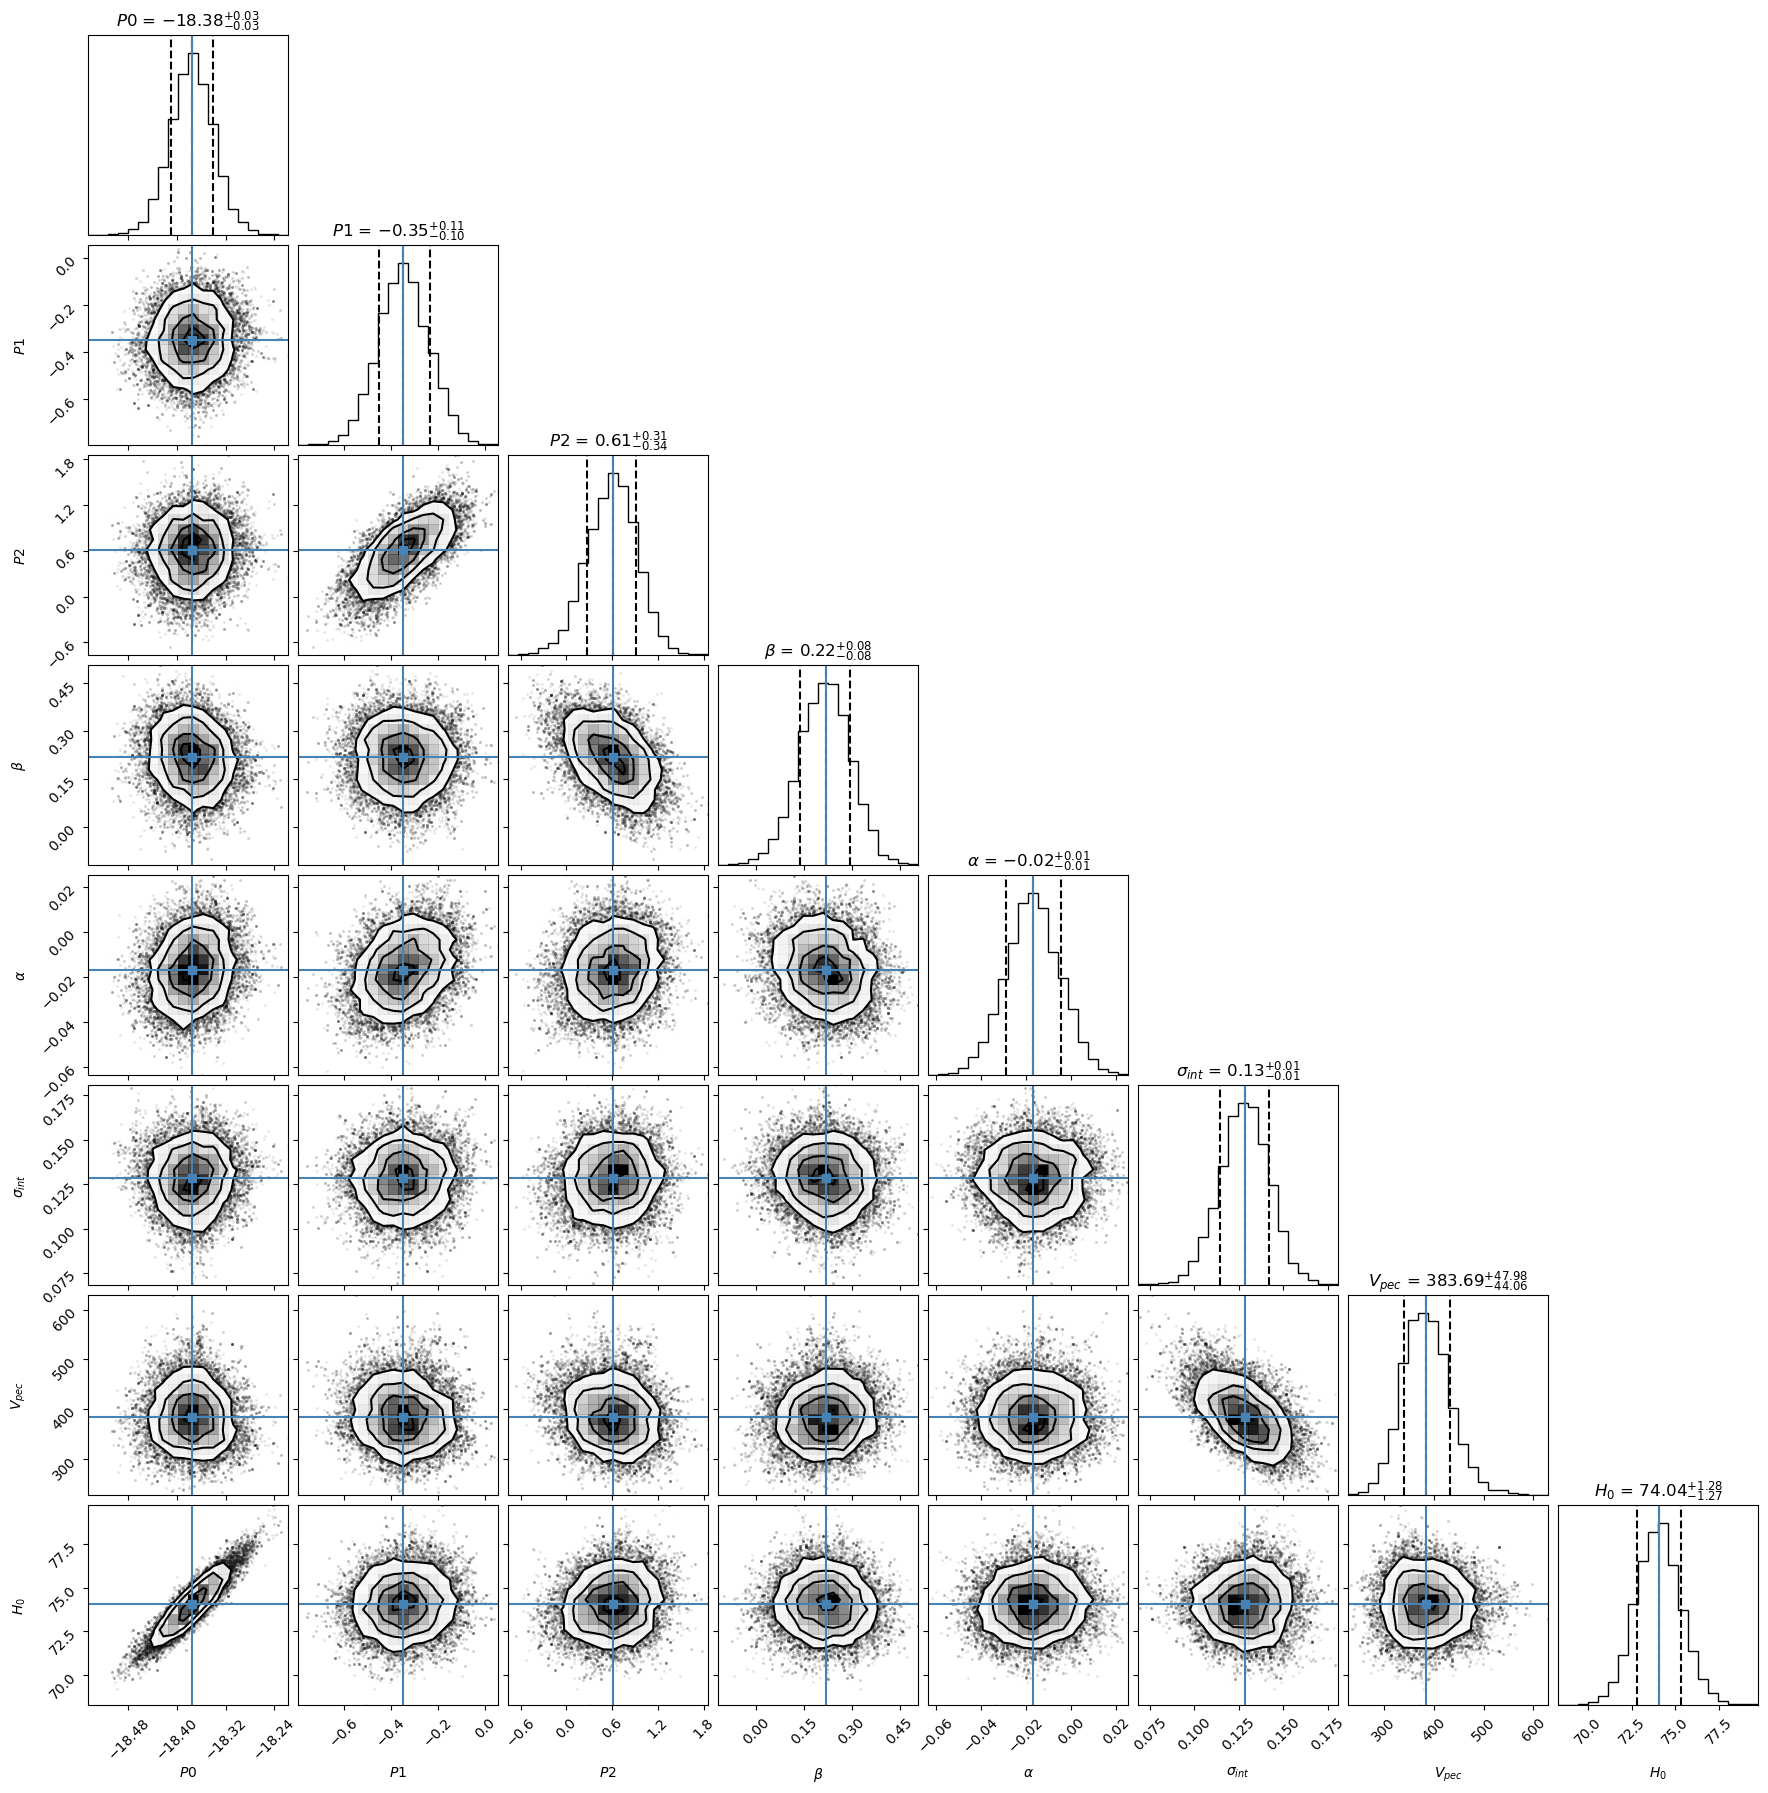

In [388]:
# Triangle plot
figure = corner.corner(samples,labels=["$P0$","$P1$", "$P2$", r"$\beta$",r"$\alpha$", r"$\sigma_{int}$","$V_{pec}$", r"$H_0$"],quantiles=[0.16, 0.5, 0.84],truths=[p0_mcmc[0],p1_mcmc[0],p2_mcmc[0],rv_mcmc[0],alpha_mcmc[0],sig_mcmc[0],vel_mcmc[0],H0_mcmc[0]],show_titles=True)


#figure.savefig("/Users/suddin/Science/SNeSurveys/CSP/mcmcplots/nocut"+file[:-4]+"_"+str(nwalkers)+"_"+str(ssize)+".pdf")



#pl.hist(samples[:, 4], 500, color="k", histtype="step")
#pl.savefig("H0.pdf")


print("Serial took {0:.1f} minutes".format(serial_time/60.))